In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Input
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../data/aim_business_cluster_60101020016000109719_train.csv', 
                      names=['collectTime','metrisValue'], index_col='collectTime', 
                      header=0, 
                      parse_dates=['collectTime'])
dataset.head()

,metrisValue
collectTime,
2020-03-14 16:01:00,467.0
2020-03-14 16:11:00,603.0
2020-03-14 16:21:00,615.0
2020-03-14 16:31:00,566.0
2020-03-14 16:41:00,515.0


In [3]:
# resample & fill the nan
single_index_series = dataset['metrisValue'].resample("10T").mean().ffill()

#split the train & test data set
training_set = single_index_series[:'2020/3/21'].values
test_set = single_index_series['2020/3/22':].values

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1, 1))

In [4]:
# Generate the train data, which contains the memory step data.
memory_step = 10
X_train = []
y_train = []
for i in range(memory_step,len(training_set_scaled)):
    X_train.append(training_set_scaled[i - memory_step:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [5]:
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=30,batch_size=150)

Epoch 1/30
1046/1046 [==============================] - 4s 4ms/step - loss: 0.1387
Epoch 2/30
1046/1046 [==============================] - 0s 293us/step - loss: 0.1031
Epoch 3/30
1046/1046 [==============================] - 0s 341us/step - loss: 0.0653
Epoch 4/30
1046/1046 [==============================] - 1s 499us/step - loss: 0.0507
Epoch 5/30
1046/1046 [==============================] - 0s 467us/step - loss: 0.0400
Epoch 6/30
1046/1046 [==============================] - 1s 533us/step - loss: 0.0294
Epoch 7/30
1046/1046 [==============================] - 0s 439us/step - loss: 0.0195
Epoch 8/30
1046/1046 [==============================] - 0s 308us/step - loss: 0.0134
Epoch 9/30
1046/1046 [==============================] - 0s 290us/step - loss: 0.0111
Epoch 10/30
1046/1046 [==============================] - 0s 348us/step - loss: 0.0110
Epoch 11/30
1046/1046 [==============================] - 0s 365us/step - loss: 0.0103
Epoch 12/30
1046/1046 [==============================] - 0s 329us

In [7]:
dataset_total = pd.concat((single_index_series[:'2020/3/21'], single_index_series['2020/3/22':]), axis=0)
inputs = dataset_total[len(single_index_series)-len(test_set) - memory_step:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

X_test = []
for i in range(memory_step, len(inputs)):
    X_test.append(inputs[i-memory_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_metrisValue = regressorGRU.predict(X_test)
predicted_metrisValue = sc.inverse_transform(predicted_metrisValue)

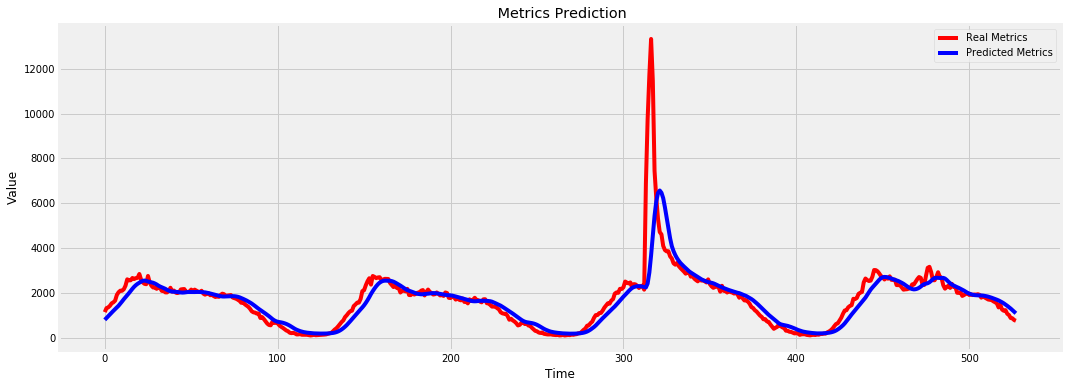

The root mean squared error is 820.7768055978136.


In [8]:
# LossFunction
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    
def plot_predictions(test,predicted):
    plt.figure(figsize=(16, 6))
    plt.plot(test, color='red',label='Real Metrics')
    plt.plot(predicted, color='blue',label='Predicted Metrics')
    plt.title(' Metrics Prediction')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
# return_rmse(test_set ,predicted_metrisValue)
plot_predictions(test_set, predicted_metrisValue)
return_rmse(test_set, predicted_metrisValue)